In [1]:
import pandas as pd
import json
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm

In [2]:
def get_df(k,dist,selection_type):
    selection_cache = pd.read_csv('data/selection_cache.csv')
    coords = pd.read_csv('data/coordinate_columns.csv')
    wind_data = pd.read_csv(f'data/filtered_historicalForecasts/{dist}km_historicalForecast2024.csv')
    energy_data = pd.read_csv('data/historical_energy.csv')
    energy_data['period'] = pd.to_datetime(energy_data['period'])
    energy_data.set_index('period', inplace=True)
    energy_series = energy_data['Megawatthours']
    energy_series.index = pd.to_datetime(energy_series.index, utc=True)
    energy_series = energy_series.sort_index()
    energy_series = energy_series['2024-01-01':'2024-12-31']

    sensor_ids = json.loads(selection_cache[(selection_cache['k']==k) & (selection_cache['dist'] == dist) & (selection_cache['selection_type'] == selection_type)]['selections'].values[0])

    kept_columns = []
    for sensor_id in sensor_ids:
        kept_columns.append('u80_' + str(sensor_id))
        kept_columns.append('v80_' + str(sensor_id))

    wind_data['Date'] = pd.to_datetime(wind_data['Date'], format='mixed', errors='coerce')
    wind_data.index = wind_data['Date']
    wind_data = wind_data[kept_columns]

    wind_data.index = wind_data.index.tz_localize(None)
    energy_series.index = energy_series.index.tz_localize(None)

    combined_df = wind_data.join(energy_series.rename('Energy'), how='inner').dropna()
    return combined_df

In [3]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
def run_ols_with_rmse(df, target_col='Energy', test_size=0.2, random_state=42):
    # Separate predictors and response
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Add 1-step lag to all predictors
    X_lagged = X.shift(1)
    y = y.iloc[1:]         # drop first row to align with lagged X
    X_lagged = X_lagged.iloc[1:]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_lagged, y, test_size=test_size, random_state=random_state
    )

    # Add constant term (intercept) to both sets
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    # Fit OLS model
    model = sm.OLS(y_train, X_train).fit()

    # Predict on test set
    y_pred = model.predict(X_test)

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return model, rmse, y_test, y_pred

In [4]:
dist = 10
selection_cache = pd.read_csv('data/selection_cache.csv')
arr = selection_cache[(selection_cache['dist'] == dist) & (selection_cache['selection_type'] == selection_type)]['k']
k_arr = np.sort(arr.unique())

NameError: name 'selection_type' is not defined

In [9]:
rmse_dict = {}
predictions_dict = {}
dist = 10
selection_types = ['optimized', 'random', 'geographic', 'variance']
k = 15

print(f'{k} ', end=' ')
for selection_type in selection_types:
    df = get_df(k, dist, selection_type)
    model, rmse, y_test, y_pred = run_ols_with_rmse(df, target_col='Energy')
    rmse_dict[(k, selection_type)] = rmse
    predictions_dict[(k, selection_type)] = (y_test, y_pred)

15  

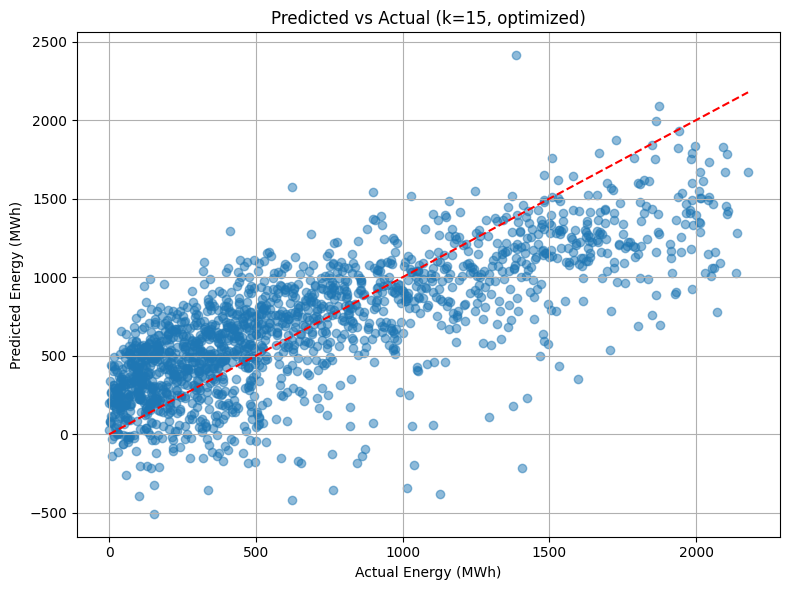

In [10]:
import matplotlib.pyplot as plt

def plot_predictions(k, selection_type, predictions_dict):
    y_test, y_pred = predictions_dict[(k, selection_type)]

    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
    plt.xlabel('Actual Energy (MWh)')
    plt.ylabel('Predicted Energy (MWh)')
    plt.title(f'Predicted vs Actual (k={k}, {selection_type})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    
plot_predictions(k=15, selection_type='optimized', predictions_dict=predictions_dict)

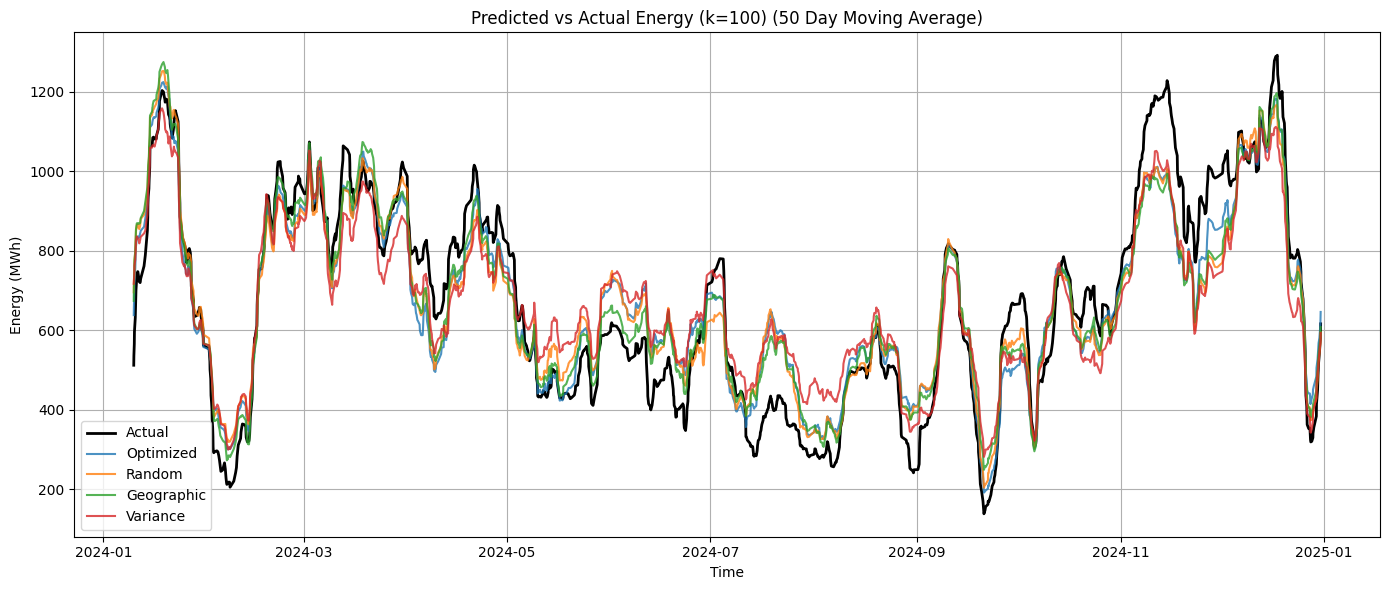

In [278]:
def plot_time_series_predictions_clean(k, predictions_dict, window=24):
    import matplotlib.pyplot as plt
    import pandas as pd

    plt.figure(figsize=(14, 6))

    # Get actual (sorted)
    y_test, _ = predictions_dict[(k, 'optimized')]
    y_test_sorted = y_test.sort_index()

    # Smooth actual using rolling mean (optional)
    y_test_smooth = y_test_sorted.rolling(window).mean()

    # Plot actual
    plt.plot(y_test_smooth, label='Actual', color='black', linewidth=2)

    # Plot each prediction (smoothed)
    for selection_type, color in zip(
        ['optimized', 'random', 'geographic', 'variance'],
        ['dodgerblue', 'orange', 'forestgreen', 'firebrick']
    ):
        _, y_pred = predictions_dict[(k, selection_type)]
        y_pred_aligned = y_pred.reindex(y_test_sorted.index)
        y_pred_smooth = pd.Series(y_pred_aligned).rolling(window).mean()
        plt.plot(y_pred_smooth, label=selection_type.capitalize(), alpha=0.8)

    plt.xlabel('Time')
    plt.ylabel('Energy (MWh)')
    plt.title(f'Predicted vs Actual Energy (k={k}) (50 Day Moving Average)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
plot_time_series_predictions_clean(k=100, predictions_dict=predictions_dict, window=50)

In [13]:
def plot_time_series_predictions_dual(k, predictions_dict, window=50):
    import matplotlib.pyplot as plt
    import pandas as pd

    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Get actual (sorted)
    y_test, _ = predictions_dict[(k, 'optimized')]
    y_test_sorted = y_test.sort_index()

    # --- First Plot: Raw Predictions ---
    axes[0].plot(y_test_sorted, label='Actual', color='black', linewidth=2)

    for selection_type, color in zip(
        ['optimized', 'random', 'geographic', 'variance'],
        ['dodgerblue', 'orange', 'forestgreen', 'firebrick']
    ):
        _, y_pred = predictions_dict[(k, selection_type)]
        y_pred_aligned = y_pred.reindex(y_test_sorted.index)
        axes[0].plot(y_pred_aligned, label=selection_type.capitalize(), alpha=0.8)

    axes[0].set_title(f'Raw Predictions vs Actual Energy (k={k})')
    axes[0].set_ylabel('Energy (MWh)')
    axes[0].grid(True)

    # --- Second Plot: Smoothed Predictions ---
    y_test_smooth = y_test_sorted.rolling(window).mean()
    axes[1].plot(y_test_smooth, label='Actual', color='black', linewidth=2)

    for selection_type, color in zip(
        ['optimized', 'random', 'geographic', 'variance'],
        ['dodgerblue', 'orange', 'forestgreen', 'firebrick']
    ):
        _, y_pred = predictions_dict[(k, selection_type)]
        y_pred_aligned = y_pred.reindex(y_test_sorted.index)
        y_pred_smooth = pd.Series(y_pred_aligned).rolling(window).mean()
        axes[1].plot(y_pred_smooth, label=selection_type.capitalize(), alpha=0.8)

    axes[1].set_title(f'50-Hour Moving Average Predictions vs Actual (k={k})')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Energy (MWh)')
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

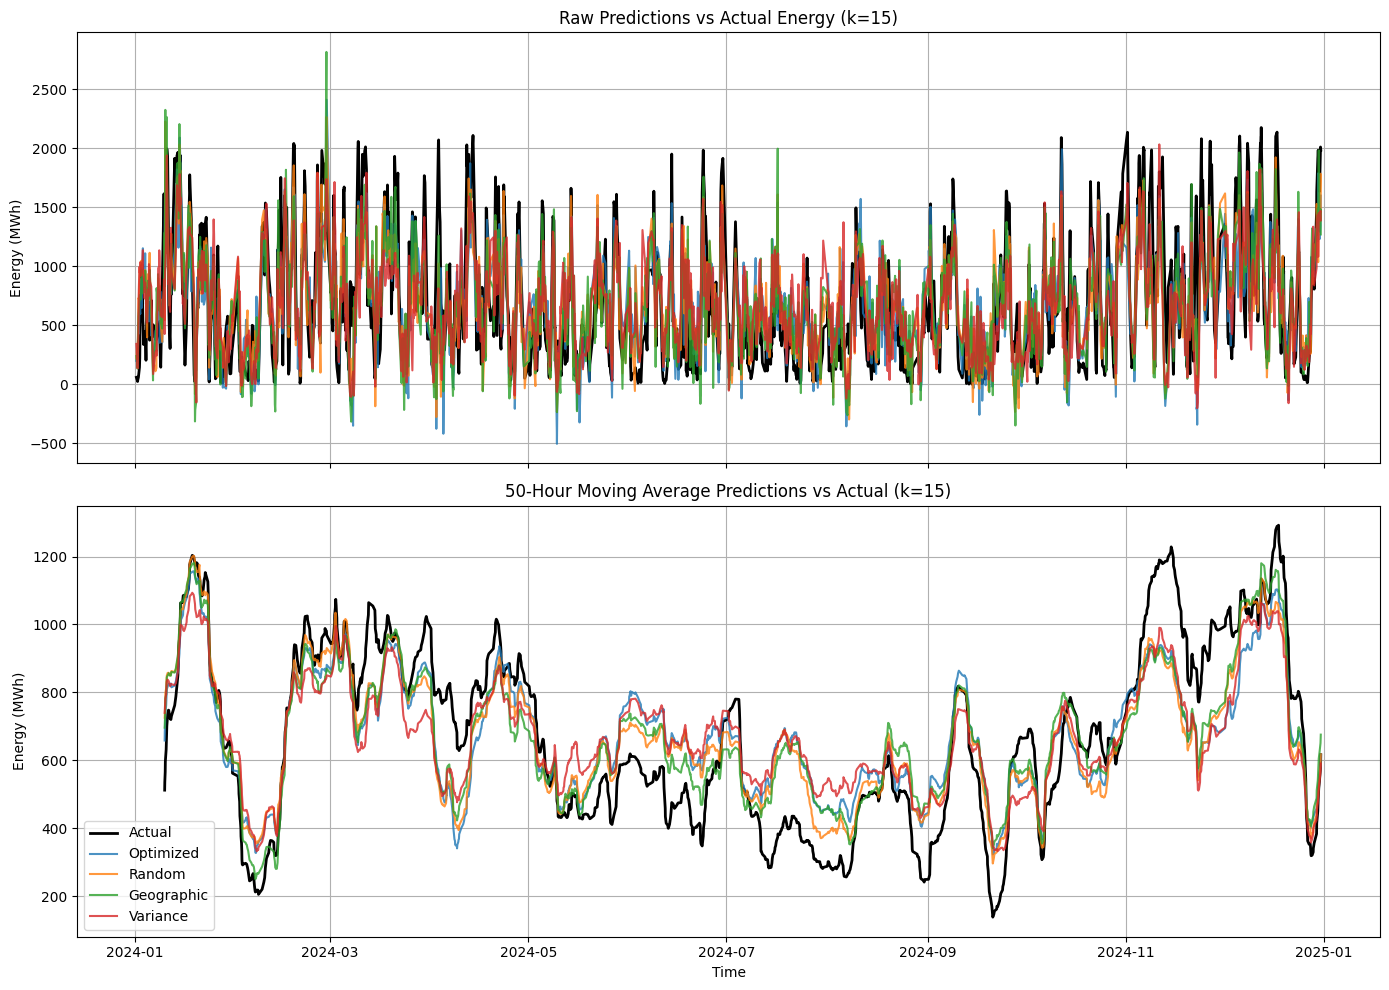

In [14]:
plot_time_series_predictions_dual(k=15, predictions_dict=predictions_dict, window=50)

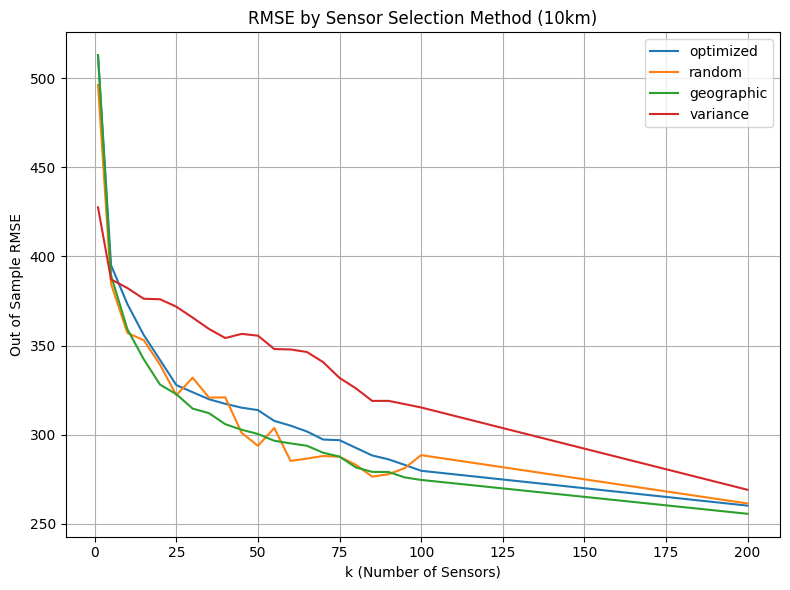

In [258]:
rmse_df = pd.DataFrame({
    selection_type: [rmse_dict[(k, selection_type)] for k in k_arr]
    for selection_type in selection_types
}, index=k_arr)

# Plot
plt.figure(figsize=(8,6))
for selection_type in selection_types:
    plt.plot(rmse_df.index, rmse_df[selection_type], label=selection_type)

plt.xlabel('k (Number of Sensors)')
plt.ylabel('Out of Sample RMSE')
plt.title(f'RMSE by Sensor Selection Method ({dist}km)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [272]:
df = get_df(15, 10, 'optimized')
model, rmse, y_test, y_pred = run_ols_with_rmse(df, target_col='Energy')

In [274]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Energy   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     294.7
Date:                Mon, 05 May 2025   Prob (F-statistic):               0.00
Time:                        10:13:09   Log-Likelihood:                -49682.
No. Observations:                6800   AIC:                         9.943e+04
Df Residuals:                    6769   BIC:                         9.964e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        271.7176      7.876     34.498      0.0